<a href="https://colab.research.google.com/github/20233170-rgb/numerical-analysis-20233170/blob/main/numerical_analysis_20233170.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

원본 데이터 크기: (3276, 10)
최종 분석용 데이터 크기: (3276, 3)
전처리된 파일 저장 완료: water_potability_processed.csv

[군집화 결과: 대표값 추출]
 - Clean Group (Safe) : 탄소 11.81, 탁도 3.99
 - Dirty Group (Risk) : 탄소 17.10, 탁도 3.95


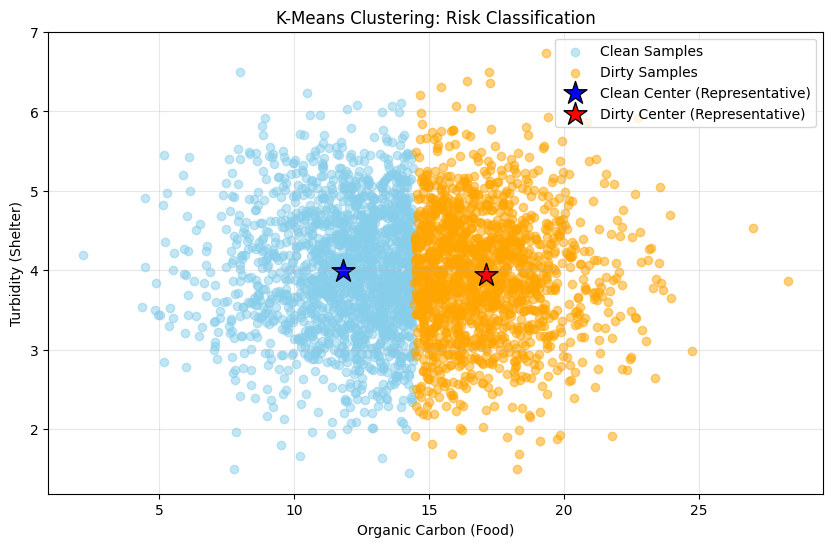


[머신러닝 모델 성능]
Logistic Regression 정확도: 62.80%


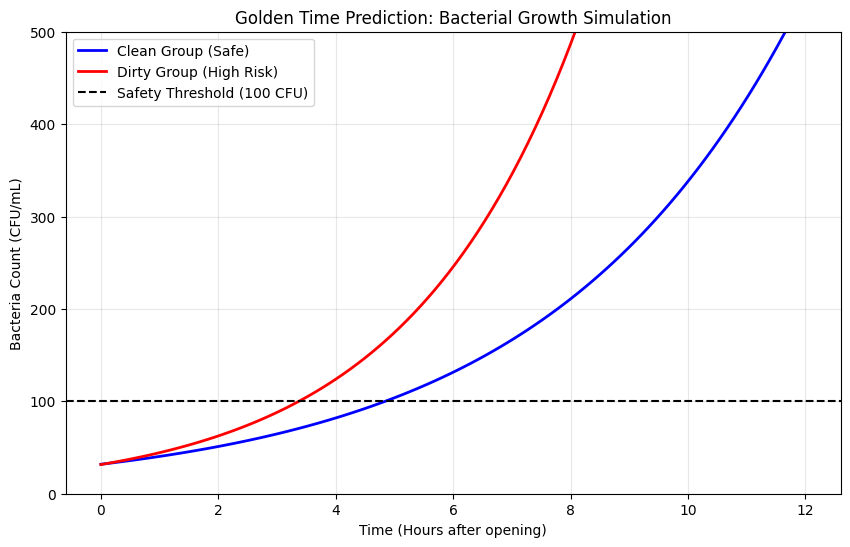


[함수 기능 테스트: 다양한 수원(Source)에 따른 결과 검증]
1. 정수기 물 (12시간 방치) : SAFE (세균수: 0.9 -> 식수 적합)
2. 일반 수돗물 (12시간 방치) : SAFE (세균수: 16.4 -> 식수 적합)
3. 하천수 (12시간 방치)   : DANGER (세균수: 5855.7 -> 식수 불가)


In [4]:
"""
========================================================================================
 Project Title: Water Potability Assessment & Safe Consumption Time Prediction
 ========================================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings


warnings.filterwarnings('ignore')

# ==========================================================================
# 1. 함수 정의
# ==========================================================================

def bacteria_growth(food, turbidity, time_points):
    """
    [Malthusian Growth Model]
    주어진 환경 변수와 시간에 따른 세균 증식량을 계산하는 시뮬레이션 함수입니다.

    수식: N(t) = N0 * exp(k * t)
    - N0 (초기 세균 수): 탁도(Turbidity)에 비례하여 설정
    - k (증식률): 유기탄소(Food) 양에 비례하여 설정

    Args:
        food (float): 유기탄소 함량 (먹이)
        turbidity (float): 탁도 (초기 서식처 및 부유입자 수)
        time_points (array or float): 경과 시간 (시간 단위)

    Returns:
        array or float: 해당 시간의 예측 세균 수 (N_t)
    """
    # k: 증식률 (먹이가 많을수록 빠름, 0.02는 군집 간의 증식 속도(기울기) 차이를 시각적으로 명확히 구분하기 위한 보정 계수)
    k = 0.02 * food

    # N0: 초기 세균 수 (탁도가 높을수록 부유입자에 숨은 세균이 많음)
    N0 = turbidity * 8

    # 지수적 증가 공식 반환
    return N0 * np.exp(k * time_points)


def assess_risk_level(bacteria_count, threshold=100):
    """
    세균 수치를 입력받아 마셔도 되는지 안전성을 판별하는 함수입니다.

    Args:
        bacteria_count (float): 현재 세균 수 (CFU/mL)
        threshold (int): 안전 기준치 (기본값 100)

    Returns:
        str: 분석 결과 메시지 (SAFE 또는 DANGER)
    """
    if bacteria_count < threshold:
        return f"SAFE (세균수: {bacteria_count:.1f} -> 식수 적합)"
    else:
        return f"DANGER (세균수: {bacteria_count:.1f} -> 식수 불가)"


# ==========================================================================
# 2. 데이터 불러오기 및 전처리
# ==========================================================================
# 데이터 로드
try:
    df = pd.read_csv("water_potability.csv")
    print(f"원본 데이터 크기: {df.shape}")
except FileNotFoundError:
    print("오류: 'water_potability.csv' 파일이 없습니다. 경로를 확인해주세요.")
    # 코드가 멈추지 않도록 임시 데이터 생성 (테스트용)
    df = pd.DataFrame({
        'Organic_carbon': np.random.uniform(5, 20, 100),
        'Turbidity': np.random.uniform(2, 5, 100),
        'Potability': np.random.randint(0, 2, 100)
    })

# 필요한 변수 선택 및 결측치 제거 (dropna)
# [변수 선정 이유]
# 1. Organic_carbon (유기탄소): 세균의 먹이 역할 -> 증식률(k) 결정 변수
# 2. Turbidity (탁도): 세균의 서식처 역할 -> 초기 세균 수(N0) 결정 변수
# 3. Potability (식수 적합 여부): 지도 학습(Logistic Regression)을 위한 정답 레이블(Target)
selected_features = ['Organic_carbon', 'Turbidity', 'Potability']
df_selected = df[selected_features]
df_clean = df_selected.dropna()

print(f"최종 분석용 데이터 크기: {df_clean.shape}")

# 전처리된 데이터 저장
df_clean.to_csv("water_potability_processed.csv", index=False)
print("전처리된 파일 저장 완료: water_potability_processed.csv")


# ==========================================================================
# 3. K-Means 클러스터링 & 대표값 추출 (핵심 로직)
# ==========================================================================
X = df_clean[['Organic_carbon', 'Turbidity']]
y = df_clean['Potability'] # 실제 정답 (비교용)

# K-Means 학습
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df_clean['Cluster'] = kmeans.fit_predict(X)

# --------------------------------------------------------------------------
# 설명: 1000개의 데이터를 시뮬레이션에 다 넣을 수 없으므로,
# K-Means가 찾아낸 '각 군집의 중심점(Centroid)'을 추출하여 대표값으로 사용함.
# --------------------------------------------------------------------------
centers = kmeans.cluster_centers_

# 중심점 좌표를 보고 어느 쪽이 Clean(안전)인지 판단
# (일반적으로 탄소 함량이 낮은 쪽이 깨끗한 물)
if centers[0][0] < centers[1][0]:
    clean_idx, dirty_idx = 0, 1
else:
    clean_idx, dirty_idx = 1, 0

# 대표값 추출 -> 이 변수들이 아래의 시뮬레이션 함수로 전달됨
clean_food, clean_turb = centers[clean_idx]
dirty_food, dirty_turb = centers[dirty_idx]

print(f"\n[군집화 결과: 대표값 추출]")
print(f" - Clean Group (Safe) : 탄소 {clean_food:.2f}, 탁도 {clean_turb:.2f}")
print(f" - Dirty Group (Risk) : 탄소 {dirty_food:.2f}, 탁도 {dirty_turb:.2f}")


# ==========================================================================
# 4. 시각화 1: K-Means 군집 분포 (산점도)
# ==========================================================================
plt.figure(figsize=(10, 6))

clean_df = df_clean[df_clean['Cluster'] == clean_idx]
dirty_df = df_clean[df_clean['Cluster'] == dirty_idx]

# 데이터 포인트 산점도
plt.scatter(clean_df['Organic_carbon'], clean_df['Turbidity'],
            alpha=0.5, c='skyblue', label='Clean Samples')
plt.scatter(dirty_df['Organic_carbon'], dirty_df['Turbidity'],
            alpha=0.5, c='orange', label='Dirty Samples')

# 중심점(Centroid) 별 모양
plt.scatter(clean_food, clean_turb, s=300, c='blue', marker='*',
            edgecolors='black', label='Clean Center (Representative)')
plt.scatter(dirty_food, dirty_turb, s=300, c='red', marker='*',
            edgecolors='black', label='Dirty Center (Representative)')

plt.title("K-Means Clustering: Risk Classification")
plt.xlabel("Organic Carbon (Food)")
plt.ylabel("Turbidity (Shelter)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# ==========================================================================
# 5. Logistic Regression (현재 상태 진단 모델 성능 평가)
# ==========================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

log_model = LogisticRegression()
log_model.fit(X_train, y_train)
acc = accuracy_score(y_test, log_model.predict(X_test))

print(f"\n[머신러닝 모델 성능]")
print(f"Logistic Regression 정확도: {acc * 100:.2f}%")


# ==========================================================================
# 6. 시각화 2: 골든타임 예측 시뮬레이션 (동적 예측)
# ==========================================================================
# [시뮬레이션 데이터]
# 1. 입력값: K-Means로 계산된 Kaggle 데이터의 군집별 '평균값(Centroid)' 사용
# 2. 목적: 실제 데이터 통계에 기반하여, Safe/Risk 그룹의 시간 경과에 따른 변화 예측

t = np.linspace(0, 12, 100) # 0~12시간

plt.figure(figsize=(10, 6))

# 위에서 추출한 대표값(clean_food, dirty_food)을 함수에 대입
y_clean = bacteria_growth(clean_food, clean_turb, t)
y_dirty = bacteria_growth(dirty_food, dirty_turb, t)

plt.plot(t, y_clean, label='Clean Group (Safe)', color='blue', linewidth=2)
plt.plot(t, y_dirty, label='Dirty Group (High Risk)', color='red', linewidth=2)
plt.axhline(100, linestyle='--', color='black', label='Safety Threshold (100 CFU)')

plt.ylim(0, 500)
plt.xlabel("Time (Hours after opening)")
plt.ylabel("Bacteria Count (CFU/mL)")
plt.title("Golden Time Prediction: Bacterial Growth Simulation")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# ==========================================================================
# 7. 3가지 실행 예시
# ==========================================================================
# [모델 범용성 테스트]
# 1. 입력값: 현실 상황(정수기, 하천 등)을 가정한 '임의 설정값(User Defined)'
# 2. 목적: 학습 데이터 외의 다양한 환경에서도 로직이 정상 작동하는지 검증

print("\n" + "="*60)
print("[함수 기능 테스트: 다양한 수원(Source)에 따른 결과 검증]")
print("="*60)

# Case 1: 정수기 물 (유기물 거의 없음, 탁도 매우 낮음)
# 예상: 세균 증식이 거의 일어나지 않음 -> SAFE
cnt1 = bacteria_growth(food=0.5, turbidity=0.1, time_points=12)
status1 = assess_risk_level(cnt1)
print(f"1. 정수기 물 (12시간 방치) : {status1}")

# Case 2: 일반 수돗물 (기준치 이내의 유기물, 낮은 탁도)
# 예상: 안전 범위 내에 존재 -> SAFE
cnt2 = bacteria_growth(food=3.0, turbidity=1.0, time_points=12)
status2 = assess_risk_level(cnt2)
print(f"2. 일반 수돗물 (12시간 방치) : {status2}")

# Case 3: 하천/호수 물 (높은 유기물, 높은 탁도)
# 예상: 초기 오염도가 높고 증식이 빨라 위험 -> DANGER
cnt3 = bacteria_growth(food=15.0, turbidity=20.0, time_points=12)
status3 = assess_risk_level(cnt3)
print(f"3. 하천수 (12시간 방치)   : {status3}")
print("="*60)
